In [1]:
import numpy as np
import cv2


# from scipy.ndimage import binary_fill_holes
from scipy import ndimage
# from skimage.morphology import skeletonize, thin
from skimage import io
from skimage import morphology
from skimage import filters

import commonfunctions
import pre_processing
import segmenter
import staff
import connected_componentes
import fit

# from pre_processing import *
# from staff import calculate_thickness_spacing, remove_staff_lines, coordinator
# from segmenter import Segmenter
# from connected_componentes import  *
# from fit import predict
# from box import Box
# import glob
# import pickle
# from imutils import resize as im_resize


In [2]:
img_name = '02'
img_ext = 'PNG'
imgs_path = '../testcases/'

In [3]:
label_map = {
    0:{
        0: 'N0'
    },
    1:{
        0:'b2',
        1:'a2'
    },
    2:{
        0:'g2',
        1:'f2'
    },
    3:{
        0:'e2',
        1:'d2'
    },
    4:{
        0:'c2',
        1:'b1'
    },
    5:{
        0:'a1',
        1:'g1'
    },
    6:{
        0:'f1',
        1:'e1'
    },
    7:{
        0:'d1',
        1:'c1'
    }
}

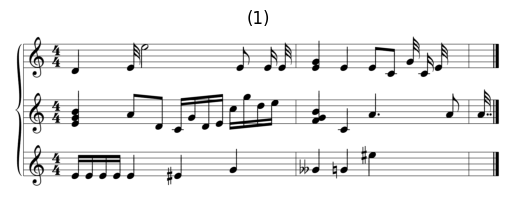

In [4]:

img = io.imread(f'{imgs_path}{img_name}.{img_ext}')[..., :3]
assert img.shape[2] == 3

img = commonfunctions.gray_img(img)
commonfunctions.show_images([img])
# img = get_thresholded(img, threshold_otsu(img))

# 楽譜が横向きの場合に、向きを変える
horizontal = pre_processing.IsHorizontal(img)
if horizontal == False:
    theta = commonfunctions.deskew(img)
    img = commonfunctions.rotation(img,theta)
    img = commonfunctions.get_gray(img)
    img = commonfunctions.get_thresholded(img, commonfunctions.threshold_otsu(img))
    img = commonfunctions.get_closer(img)
    horizontal = commonfunctions.IsHorizontal(img)
    commonfunctions.show_images([img])

(509, 1583)


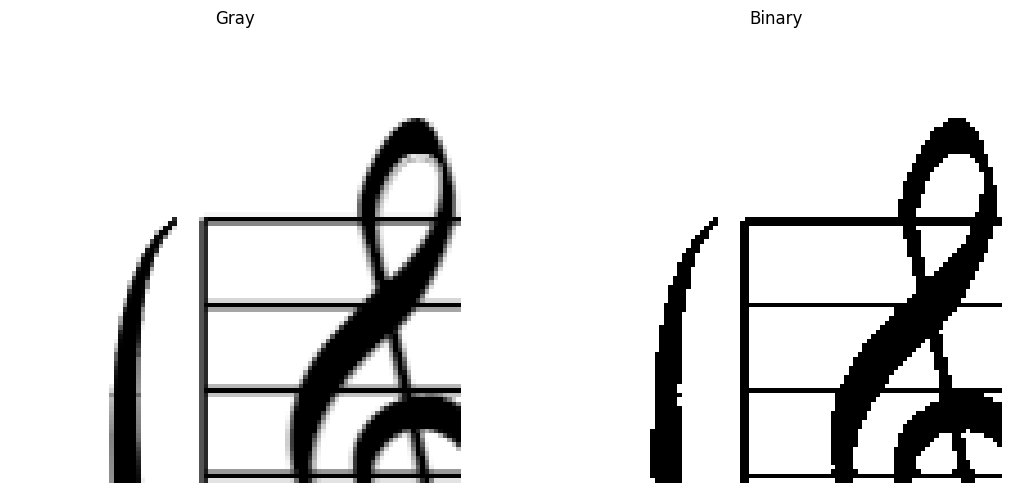

In [5]:
#img = io.imread('testcases/test-set-scanned/test-cases/02.PNG')
print(img.shape)
# if img.shape[1] < 1300:
#     img = resize(img, (img.shape[0], 2000))
# if img.shape[0] > 250:
#     img = resize(img, (250, img.shape[1]))
# print(img.shape)
original = img.copy()
# gray = commonfunctions.get_gray(img)
gray = img.copy()
bin_img = commonfunctions.get_thresholded(gray, filters.threshold_otsu(gray))
commonfunctions.show_images([gray[:100, :100], bin_img[:100, :100]], ['Gray', 'Binary'])

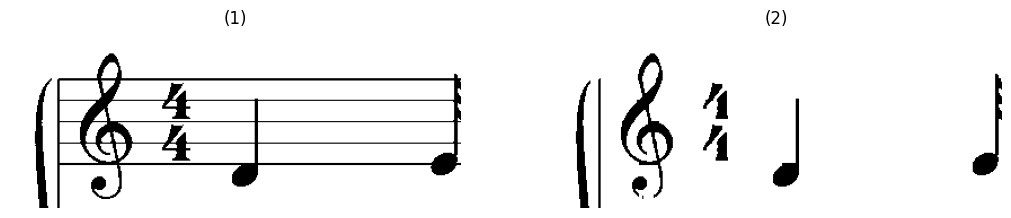

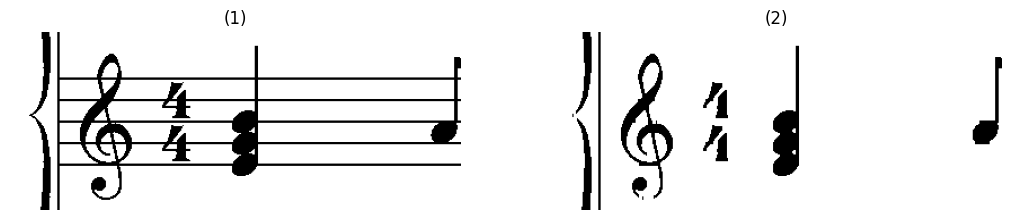

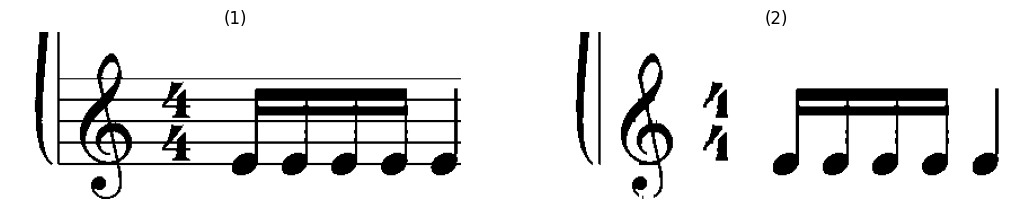

In [6]:
# 段に分けて、
# 五線 (staff) を消去する
seg = segmenter.Segmenter(bin_img)
imgs_with_staff = seg.regions_with_staff
imgs_without_staff = seg.regions_without_staff

for i, (imgw, imgwo) in enumerate(zip(imgs_with_staff, imgs_without_staff)):
    commonfunctions.show_images([imgw[:, :400], imgwo[:, :400]])

18 [22.0, 41.0, 60.0, 79.0, 98.0, 117.0, 136.0]


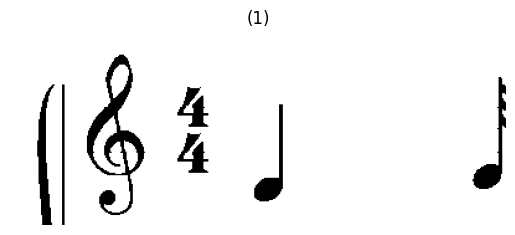

In [7]:
imgs_spacing = []  # 線の間隔 (pixel)
imgs_rows = []  # 線のあると思われる行インデックス
coord_imgs = []  # 五線を取り除いて、修復した？画像
for i, img in enumerate(imgs_with_staff):
    spacing, rows, no_staff_img = staff.coordinator(img, horizontal)
    imgs_rows.append(rows)
    imgs_spacing.append(spacing)
    coord_imgs.append(no_staff_img)

print(imgs_spacing[0], imgs_rows[0])
commonfunctions.show_images([coord_imgs[0][:, :400]])

22
41
60
79
98
117
136


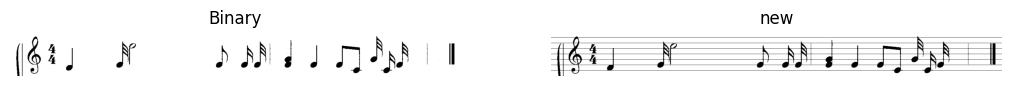

22
41
60
79
98
117
136


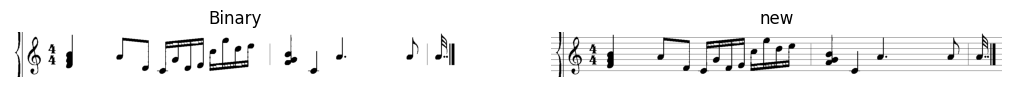

22
41
60
79
98
117
136


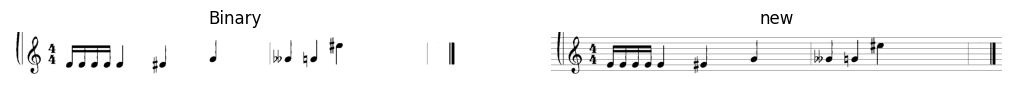

In [8]:
def draw_staff(img, row_positions):
    image = np.copy(img)
    for x in range (len(row_positions)):
        print(int(row_positions[x]))
        image[int(row_positions[x]),:] = 0
    return image

for i, img in enumerate(coord_imgs):
    new_img = draw_staff(img,imgs_rows[i])
    commonfunctions.show_images([img,new_img], ['Binary','new'])  
    cv2.imwrite(f'{img_name}_without_staff_{i}.png', np.array(255*img).astype(np.uint8))
    cv2.imwrite(f'{img_name}_with_new_staff_{i}.png', np.array(255*new_img).astype(np.uint8))

In [9]:
def get_note_name(prev, octave, duration):
    if duration in ['4', 'a_4']:
        return f'{octave[0]}{prev}{octave[1]}/4'
    elif duration in ['8', '8_b_n', '8_b_r', 'a_8']:
        return f'{octave[0]}{prev}{octave[1]}/8'
    elif duration in ['16', '16_b_n', '16_b_r', 'a_16']:
        return f'{octave[0]}{prev}{octave[1]}/16'
    elif duration in ['32', '32_b_n', '32_b_r', 'a_32']:
        return f'{octave[0]}{prev}{octave[1]}/32'
    elif duration in ['2', 'a_2']:
        return f'{octave[0]}{prev}{octave[1]}/2'
    elif duration in ['1', 'a_1']:
        return f'{octave[0]}{prev}{octave[1]}/1'

In [10]:
def filter_beams(prims, prim_with_staff, bounds):
    n_bounds = []
    n_prims = []
    n_prim_with_staff = []
    for i, prim in enumerate(prims):
        if prim.shape[1] >= 2*prim.shape[0]:
            print('filter: ', prim.shape)
            continue
        else:
            n_bounds.append(bounds[i])
            n_prims.append(prims[i])
            n_prim_with_staff.append(prim_with_staff[i])
    return n_prims, n_prim_with_staff, n_bounds

In [11]:
def get_chord_notation(chord_list):
    chord_res = "{"
    for chord_note in chord_list:
        chord_res += (str(chord_note) + ",")
    chord_res = chord_res[:-1]
    chord_res += "}"
    
    return chord_res

In [12]:
def estim(c, idx):
    print('estim idx: ', idx)
    spacing = imgs_spacing[idx]
    rows = imgs_rows[idx]
    margin = 1+(spacing/4)
    for index,line in enumerate (rows):
        if c >= line - margin and c <= line + margin:
            return index+1, 0
        elif c >= line + margin and c <= line + 3*margin:
            return index+1, 1
    return 0 , 0 

3


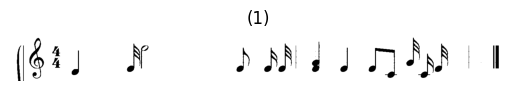

[(43, 22, 156, 36), (43, 42, 156, 44), (19, 62, 148, 109), (45, 135, 77, 160), (82, 135, 114, 160), (59, 197, 137, 220), (37, 373, 127, 416), (43, 418, 116, 442), (50, 723, 127, 765), (50, 811, 127, 854), (37, 857, 127, 900), (31, 964, 127, 988), (50, 1054, 127, 1078), (51, 1145, 146, 1235), (18, 1265, 108, 1308), (69, 1303, 146, 1352), (37, 1356, 127, 1399), (43, 1542, 116, 1546), (43, 1549, 116, 1560)]


c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


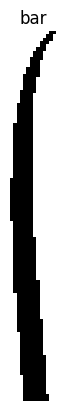

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


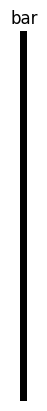

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


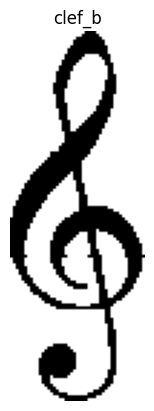

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


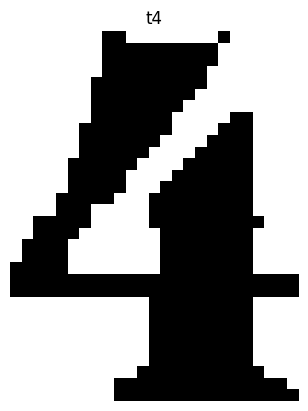

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


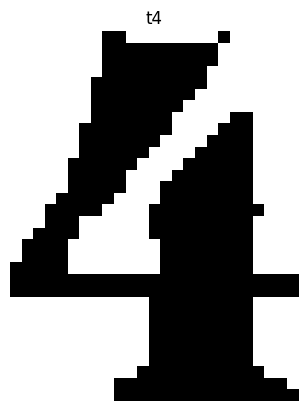

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


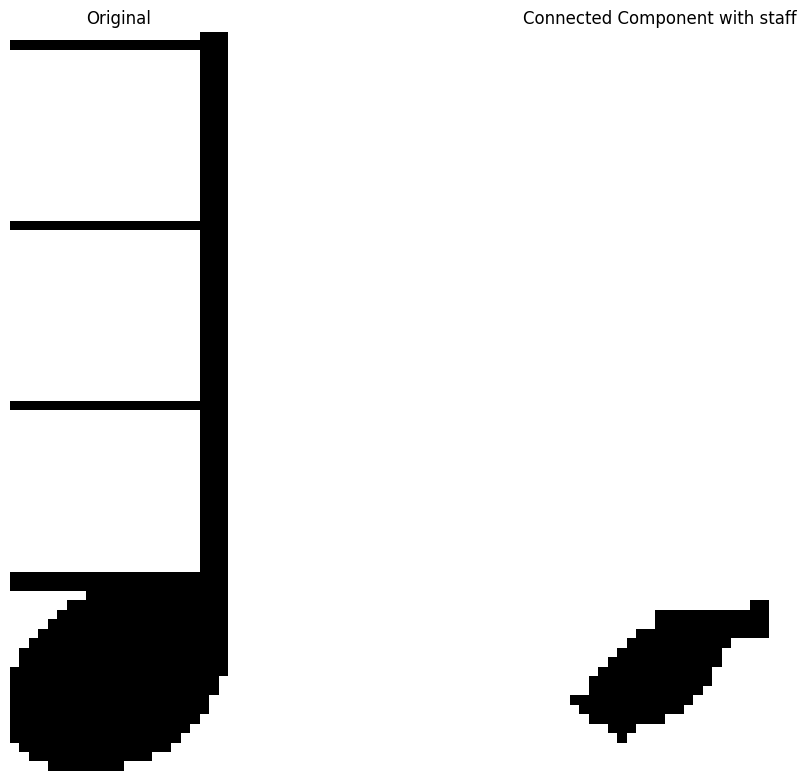

estim idx:  0
136.75
d1


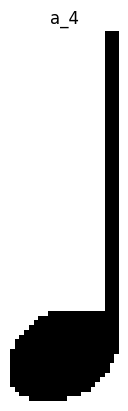

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


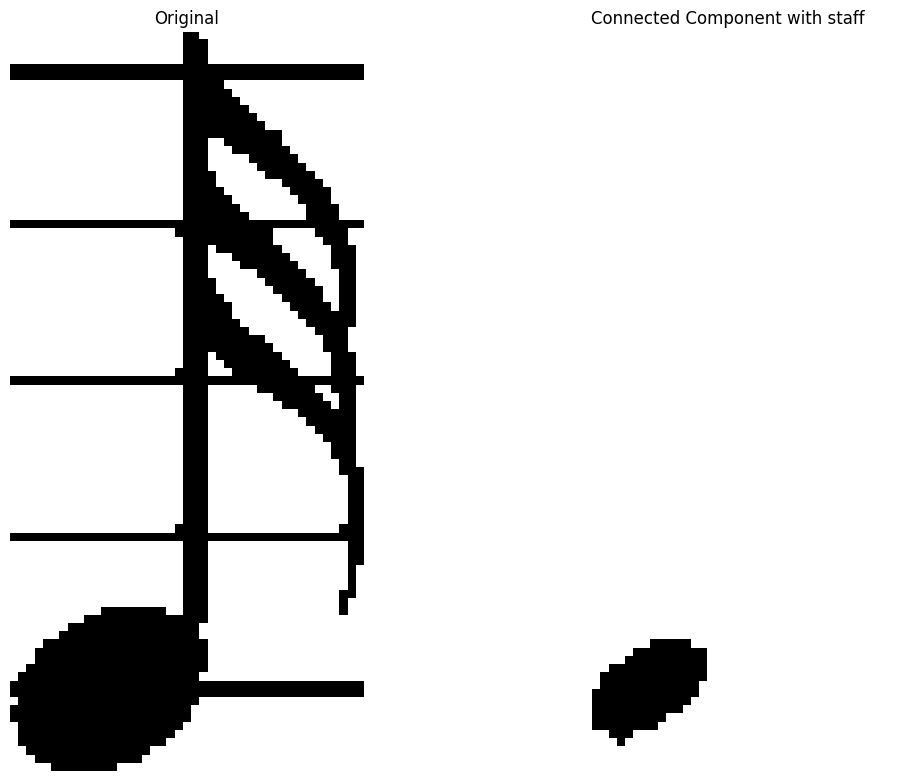

estim idx:  0
126.75
e1


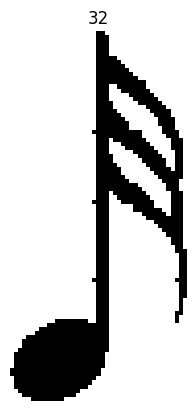

estim idx:  0
60
e2


c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


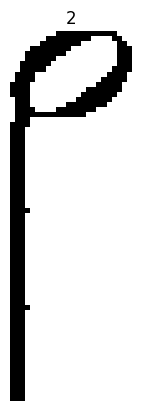

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


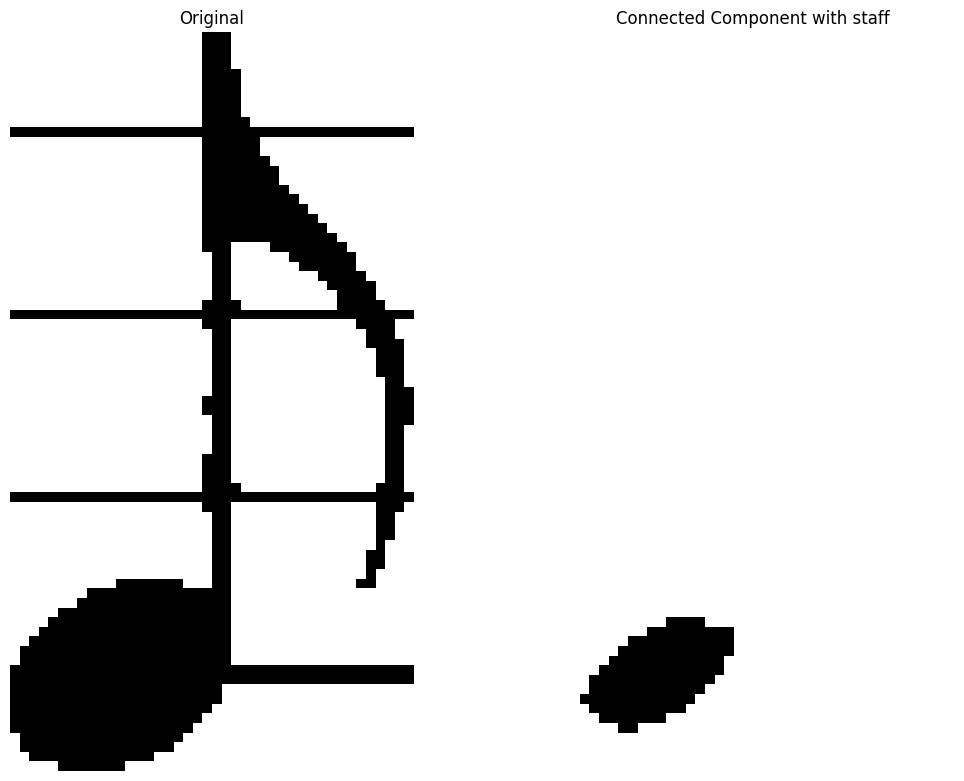

estim idx:  0
125.75
e1


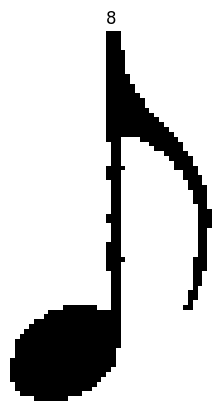

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


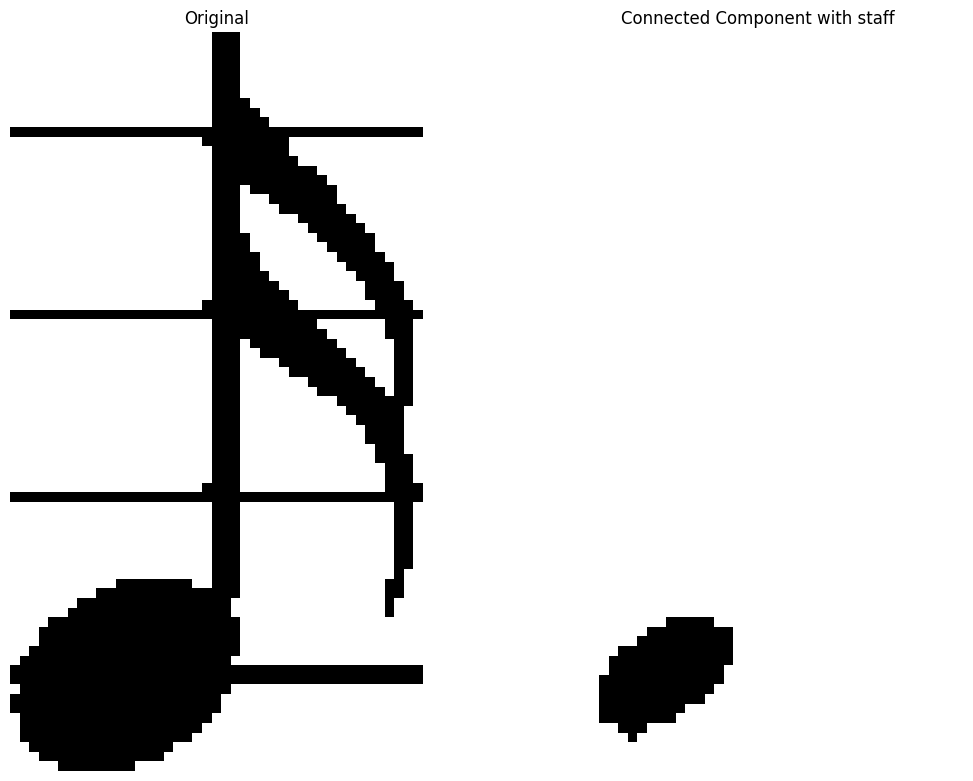

estim idx:  0
126.75
e1


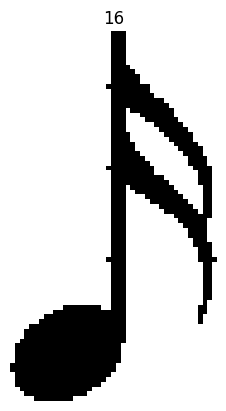

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


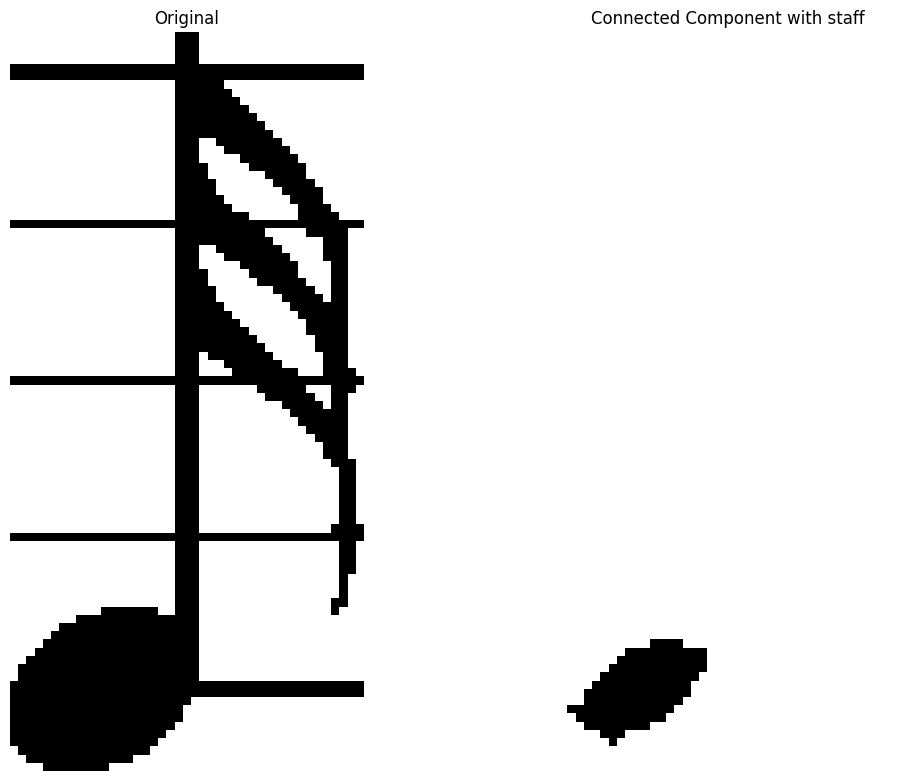

estim idx:  0
126.75
e1


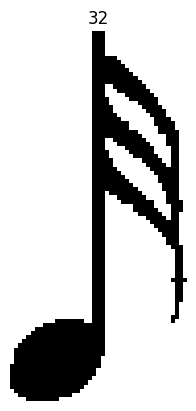

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


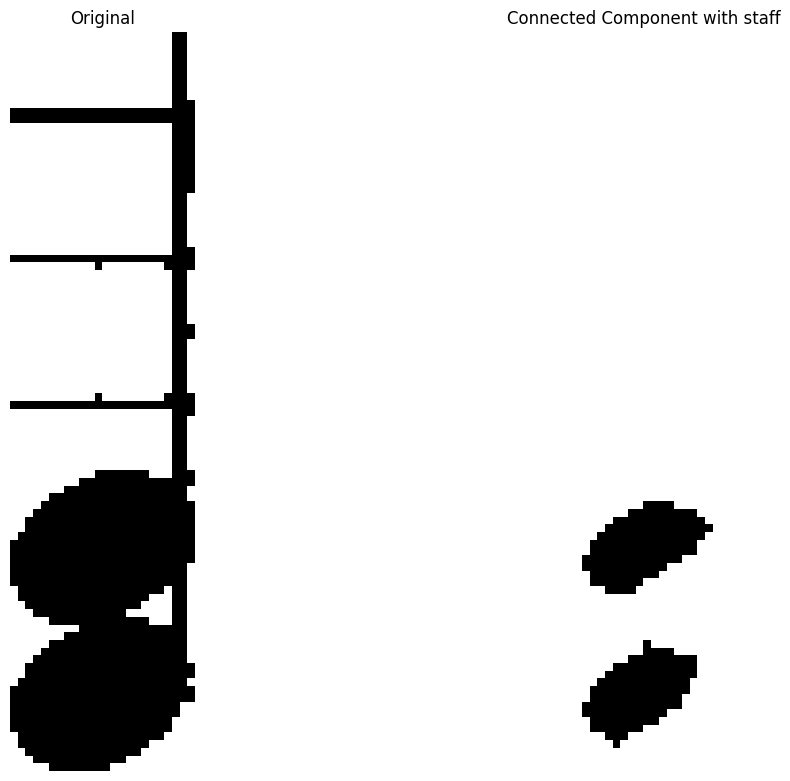

Bound
estim idx:  0
Bound
estim idx:  0


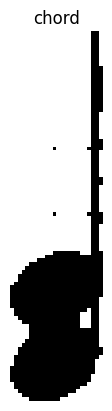

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


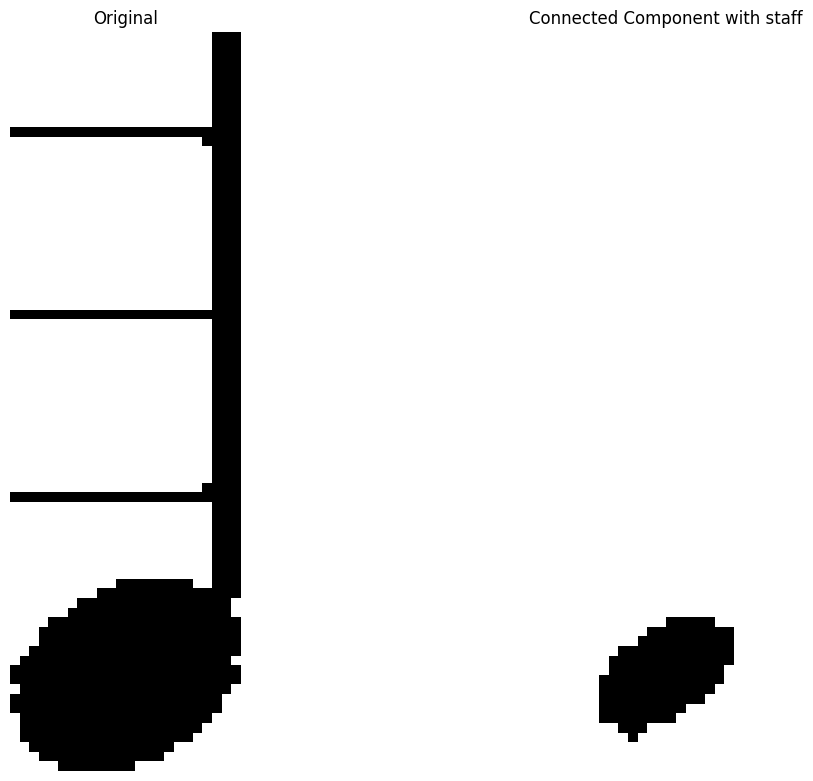

estim idx:  0
126.75
e1


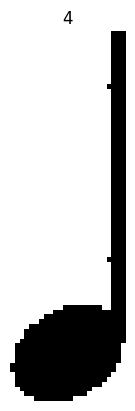

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


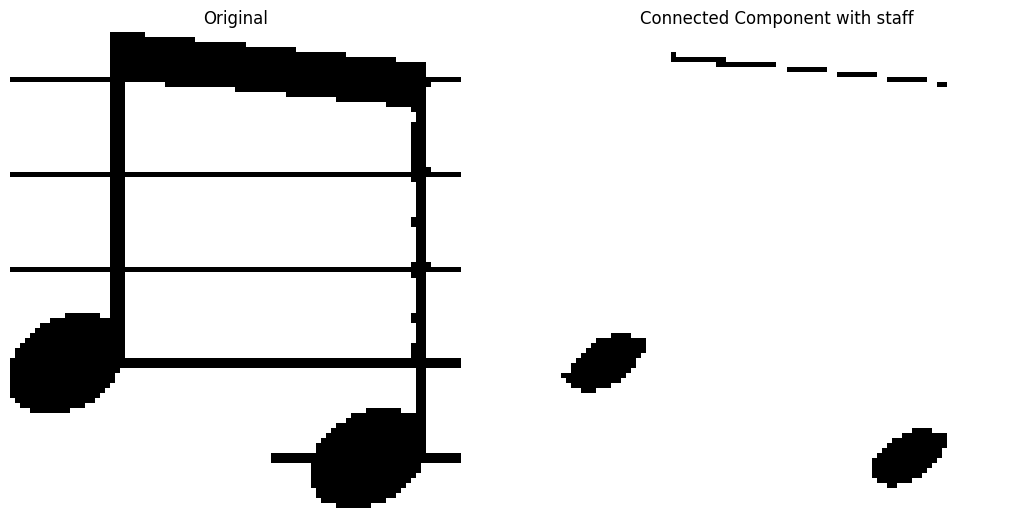

estim idx:  0
125.75
e1
estim idx:  0
144.75
c1


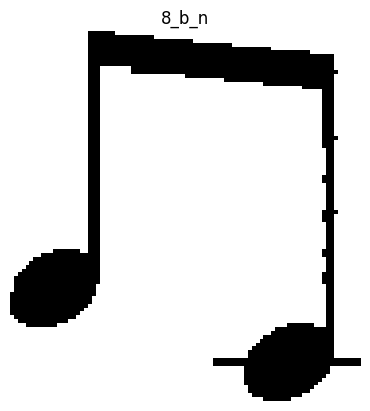

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


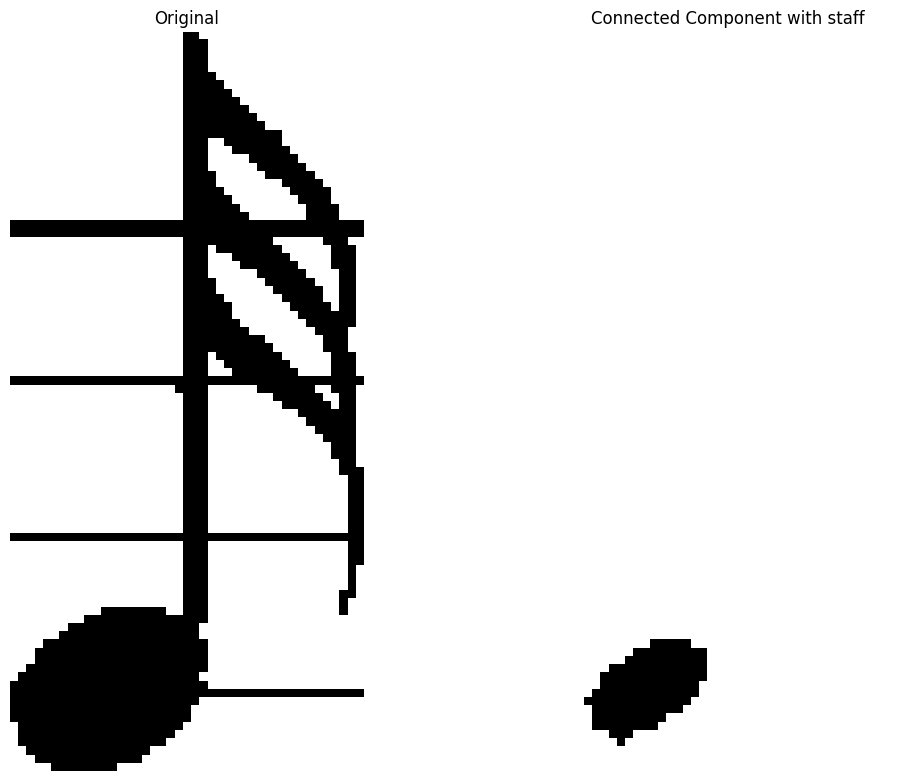

estim idx:  0
107.75
g1


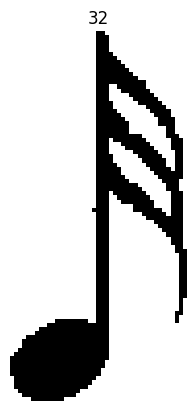

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


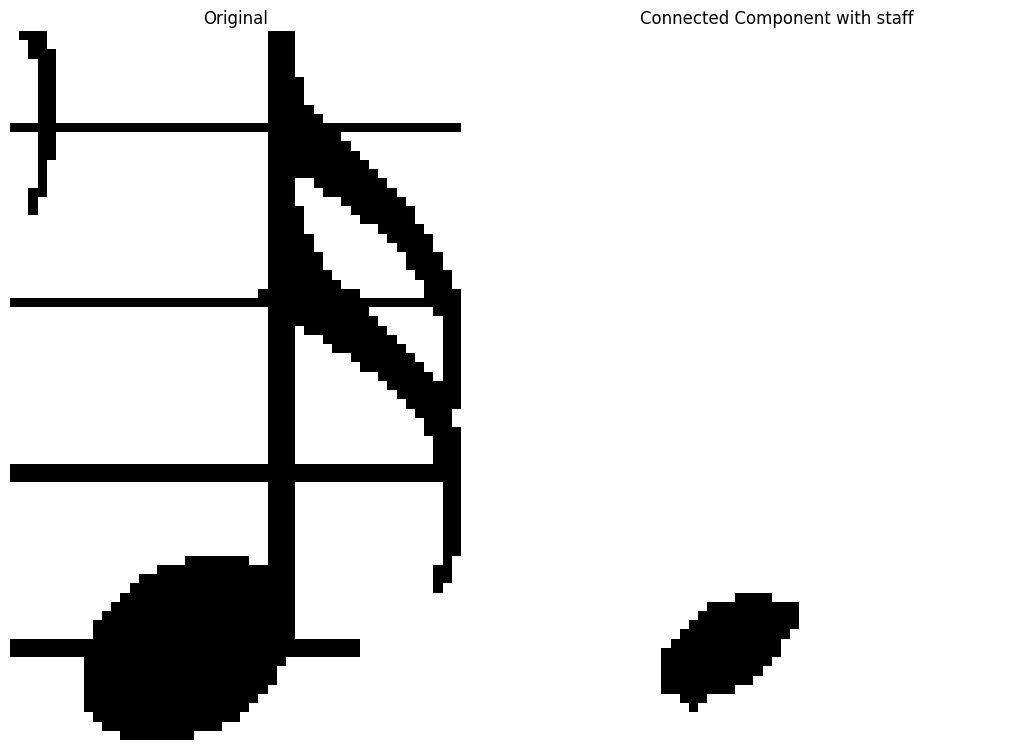

estim idx:  0
145.75
c1


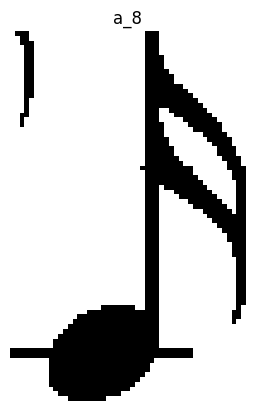

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


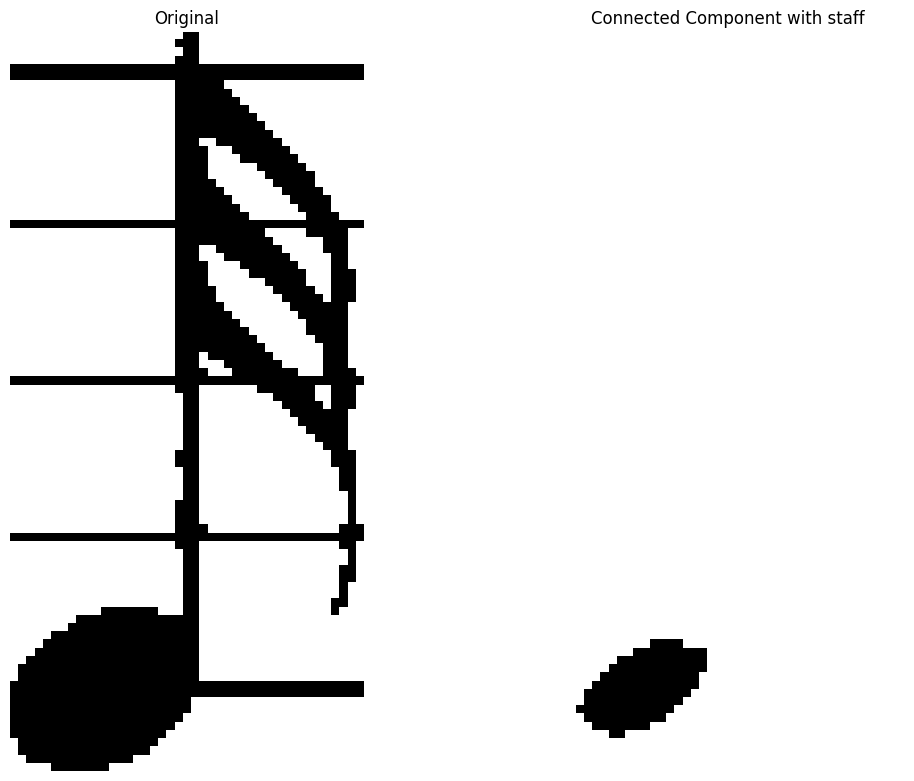

estim idx:  0
125.75
e1


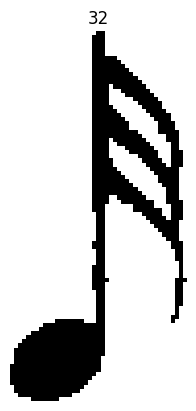

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


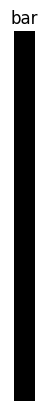

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


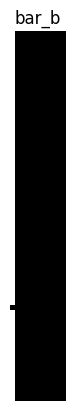

['\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', 'd1/4', 'e1/32', 'e2/2', 'e1/8', 'e1/16', 'e1/32', ['e1/4', 'g1/4'], 'e1/4', 'e1/8', 'c1/8', 'g1/32', 'c1/8', 'e1/32']


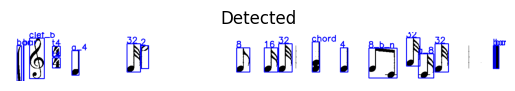

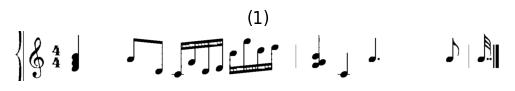

[(0, 17, 158, 36), (0, 42, 158, 44), (20, 62, 149, 108), (45, 135, 77, 160), (83, 135, 115, 160), (13, 197, 128, 220), (23, 373, 137, 487), (24, 516, 147, 680), (23, 700, 137, 857), (13, 964, 117, 1008), (69, 1046, 147, 1085), (22, 1145, 98, 1168), (22, 1392, 98, 1433), (9, 1492, 98, 1535), (43, 1542, 117, 1546), (43, 1550, 117, 1560)]


c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


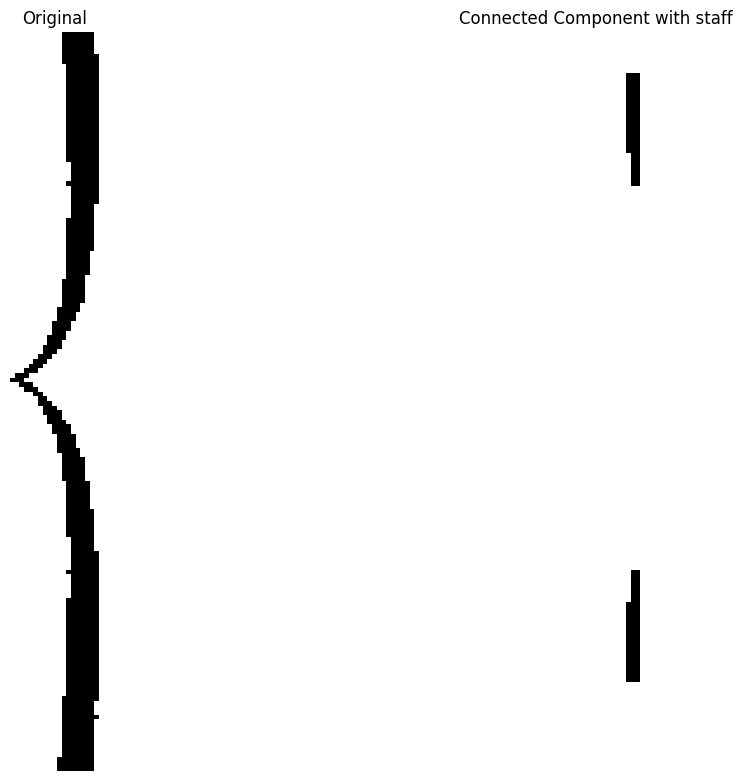

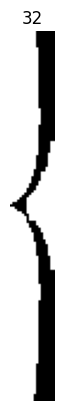

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


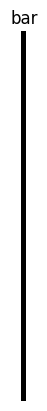

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


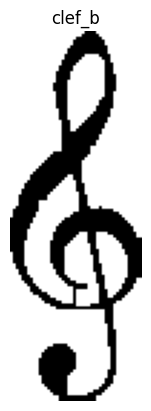

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


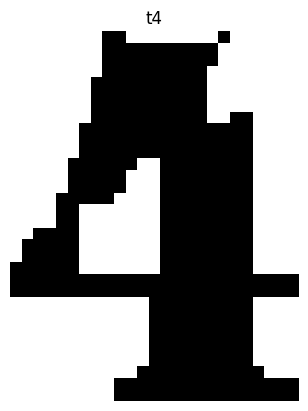

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


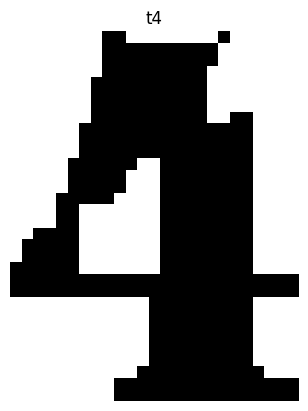

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


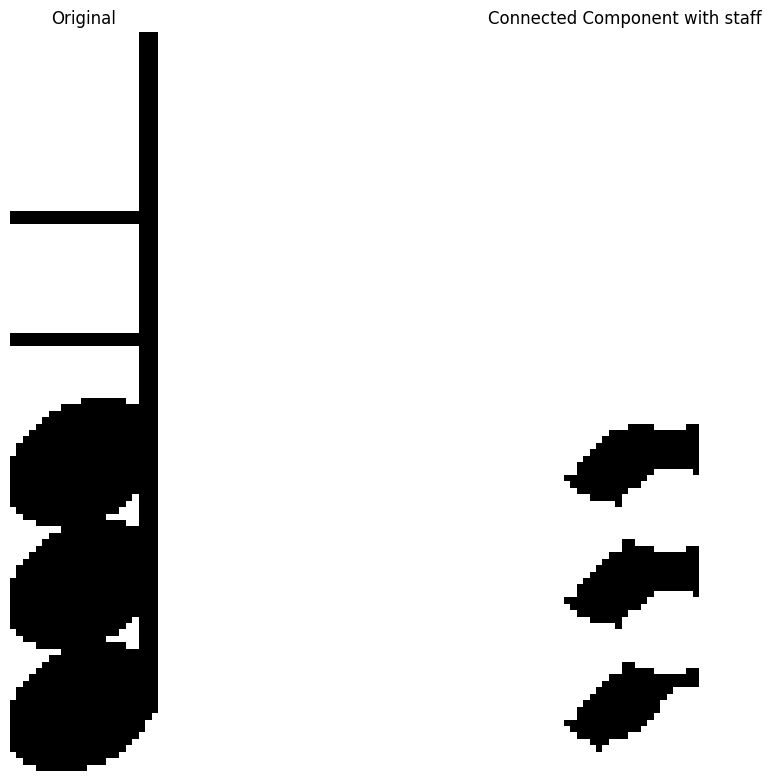

Bound
estim idx:  1
Bound
estim idx:  1
Bound
estim idx:  1


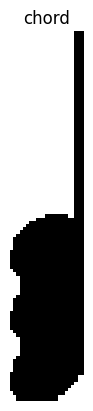

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


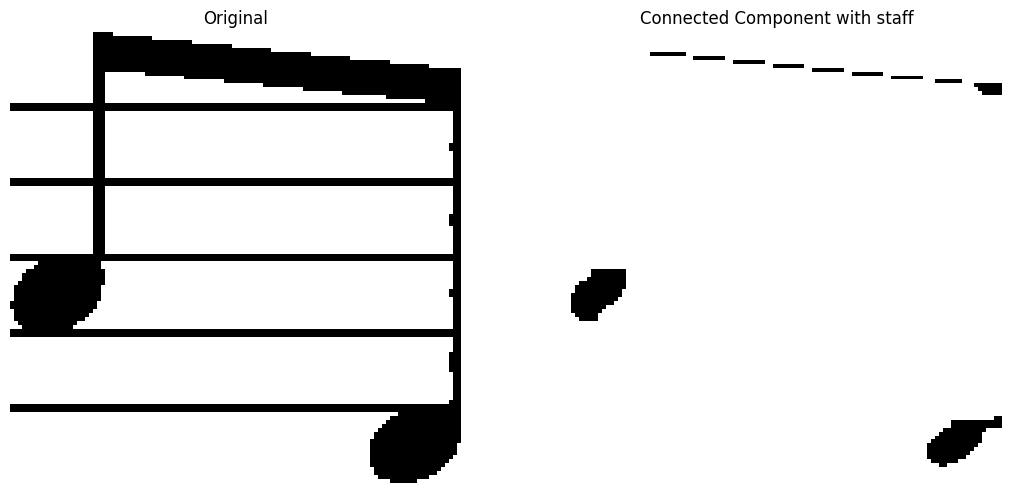

estim idx:  1
98.75
a1
estim idx:  1
135.75
d1


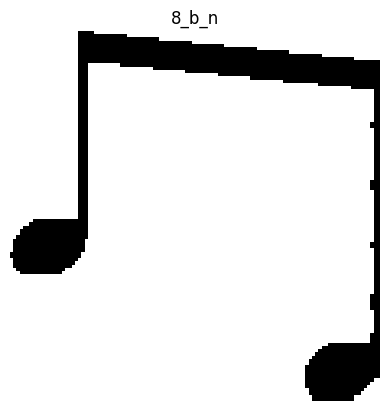

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


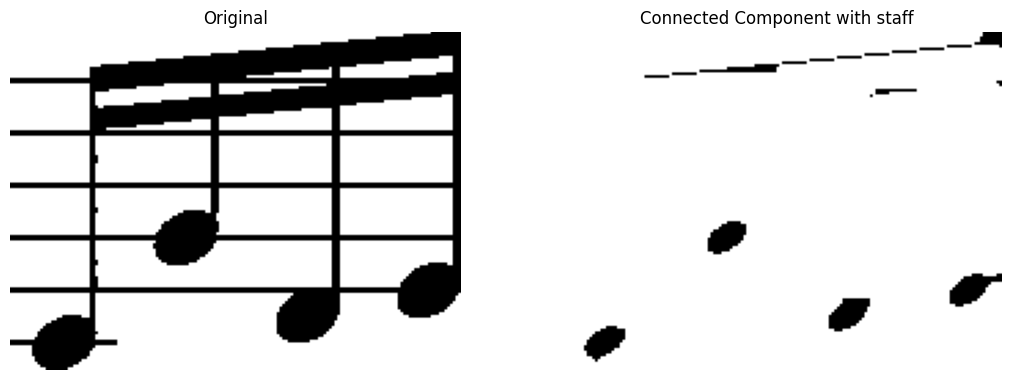

estim idx:  1
146.75
c1
estim idx:  1
107.75
g1
estim idx:  1
135.75
d1
estim idx:  1
126.75
e1


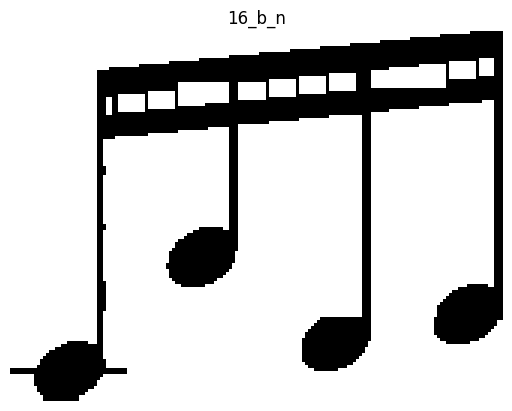

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


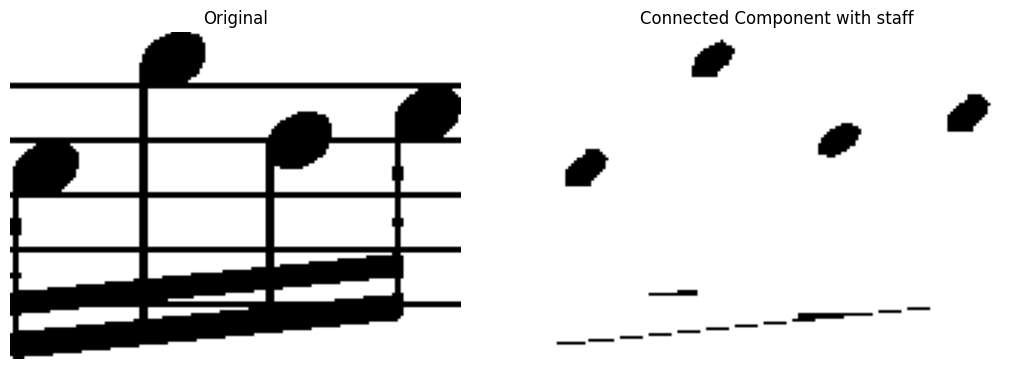

estim idx:  1
79.75
c2
estim idx:  1
41.75
g2
estim idx:  1
69.75
d2
estim idx:  1
60.75
e2


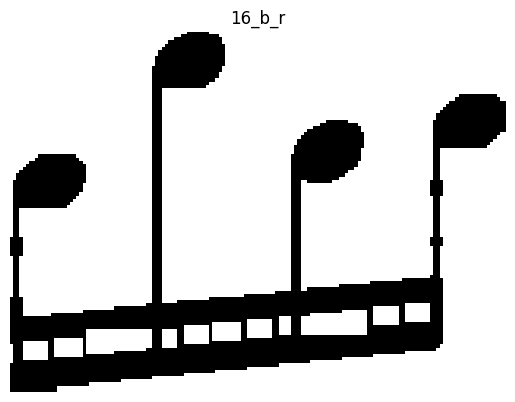

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


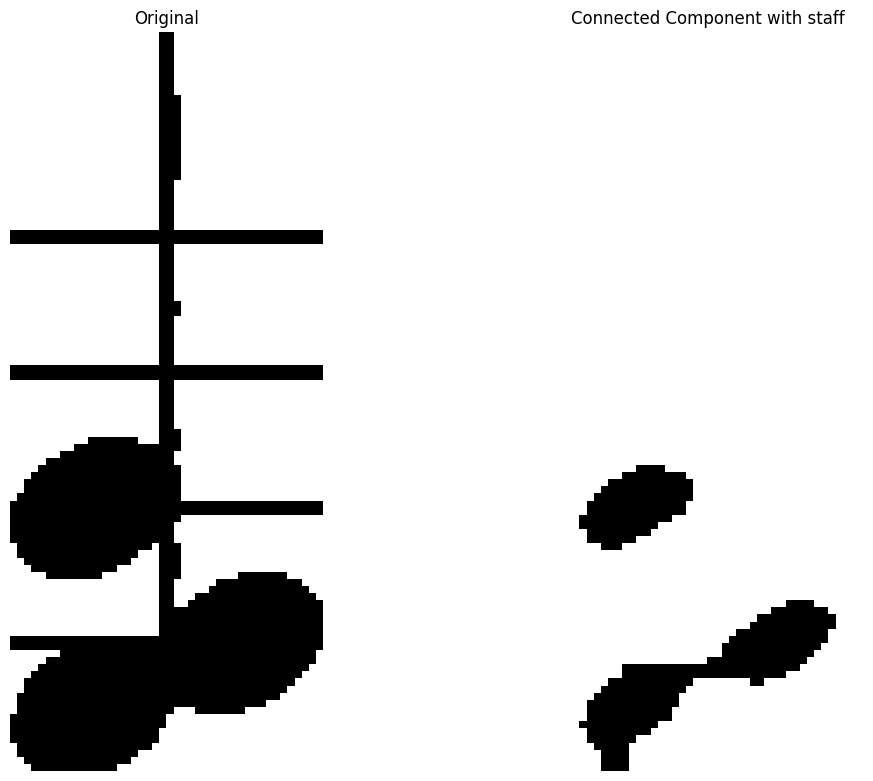

Bound
estim idx:  1
IF COND 31.0 21.25
estim idx:  1
Bound
estim idx:  1


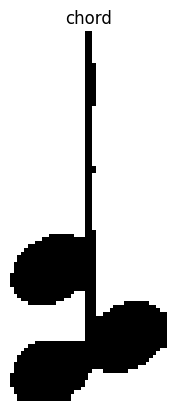

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


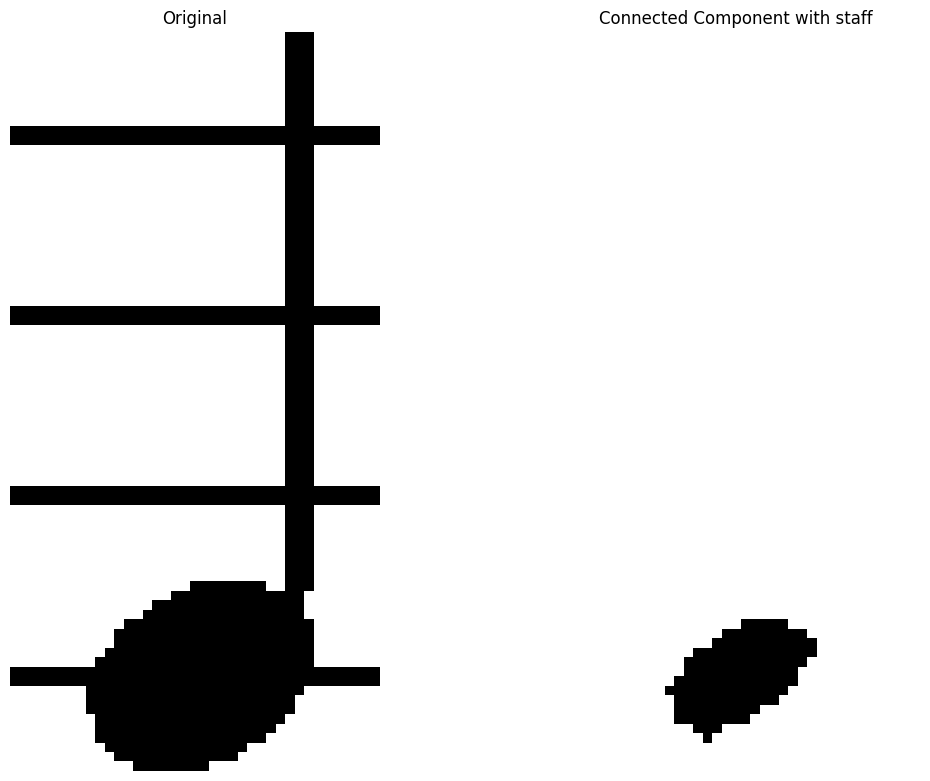

estim idx:  1
146.75
c1


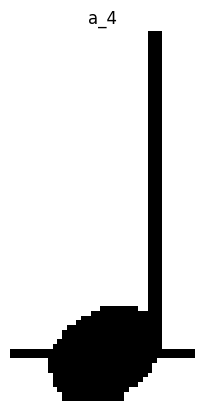

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


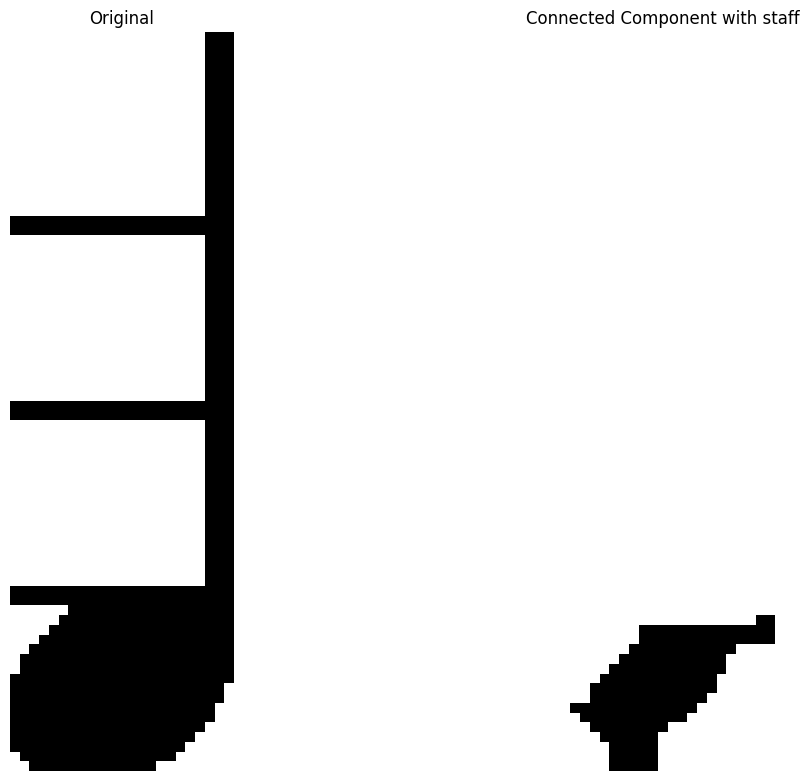

estim idx:  1
100.75
a1


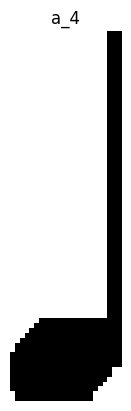

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


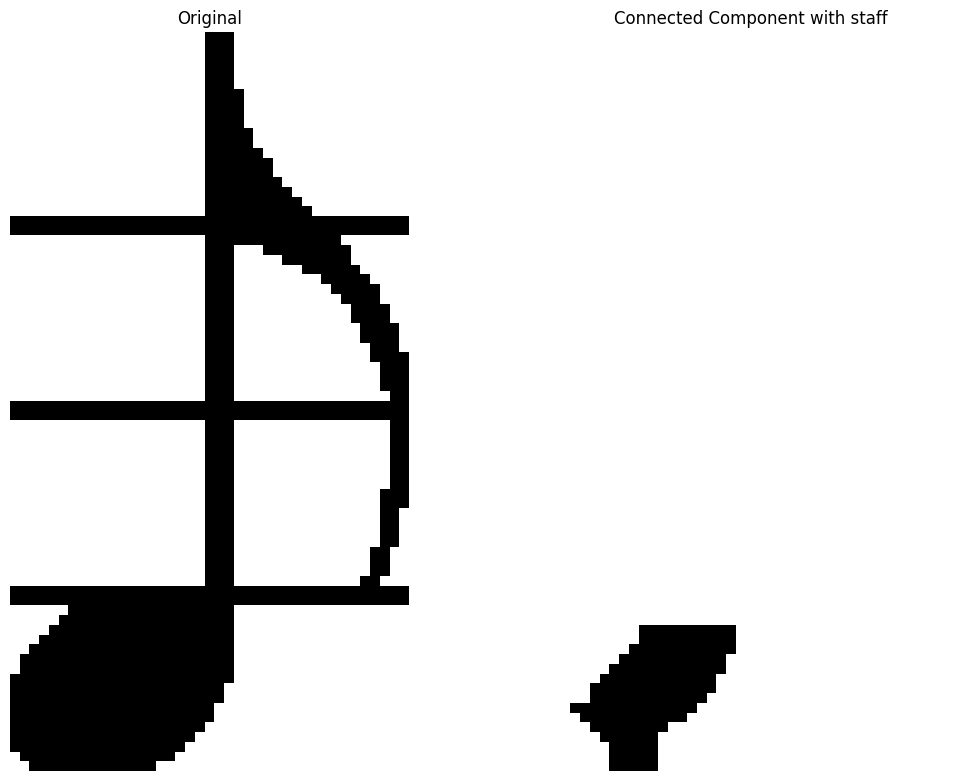

estim idx:  1
100.75
a1


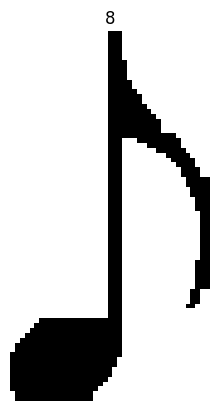

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


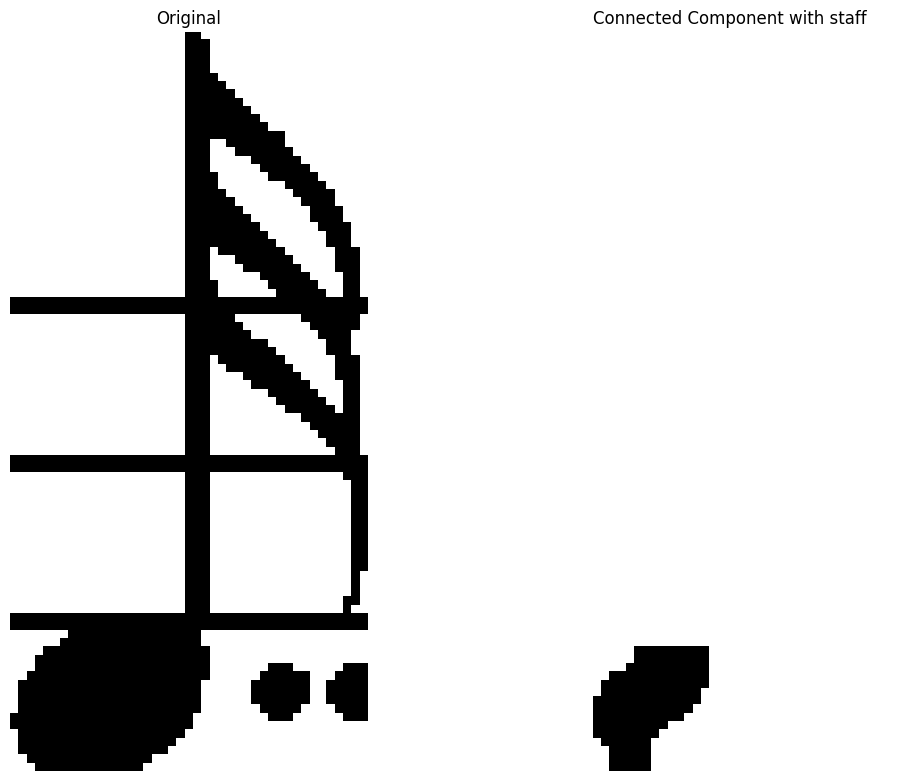

estim idx:  1
100.75
a1


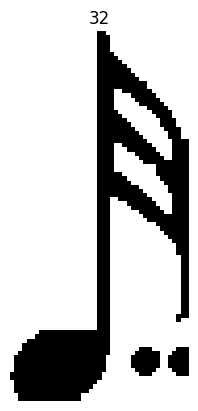

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


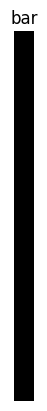

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


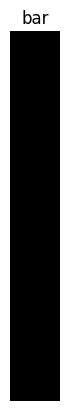

['\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', ['b1/4', 'e1/4', 'g1/4'], 'a1/8', 'd1/8', 'c1/16', 'g1/16', 'd1/16', 'e1/16', 'c2/16', 'g2/16', 'd2/16', 'e2/16', ['b1/4', 'f1/4', 'g1/4'], 'c1/4', 'a1/4', 'a1/8', 'a1/32']


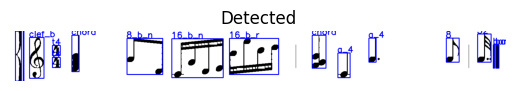

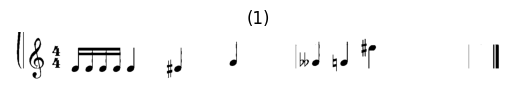

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[(0, 22, 116, 37), (0, 42, 116, 44), (19, 62, 148, 108), (44, 135, 76, 160), (82, 135, 114, 160), (50, 197, 127, 353), (50, 373, 127, 397), (88, 501, 146, 518), (50, 524, 127, 548), (31, 701, 108, 725), (65, 925, 111, 954), (31, 964, 108, 988), (72, 1030, 125, 1043), (31, 1054, 108, 1079), (22, 1121, 78, 1139), (42, 1144, 116, 1168), (40, 1542, 116, 1546), (40, 1549, 116, 1560)]


c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


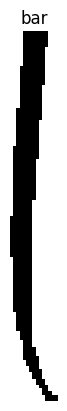

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


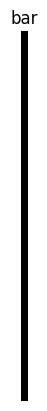

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


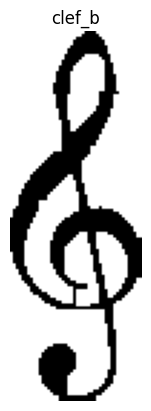

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


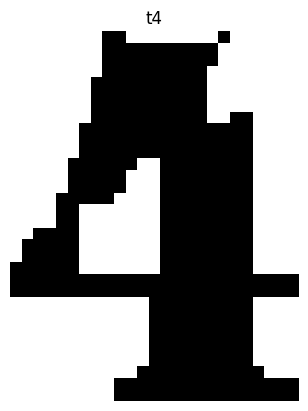

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


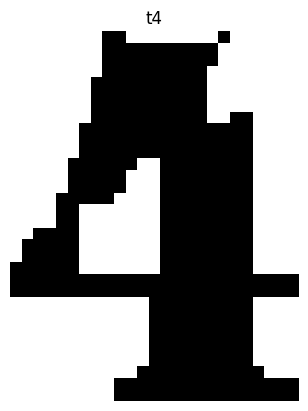

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


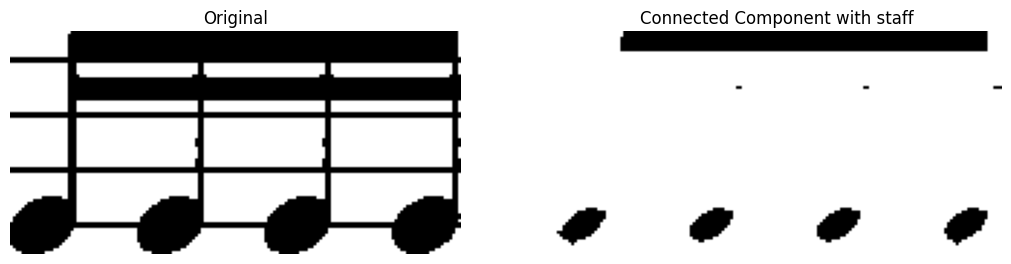

filter:  (7, 127)
estim idx:  2
126.75
e1
estim idx:  2
125.75
e1
estim idx:  2
125.75
e1
estim idx:  2
126.75
e1


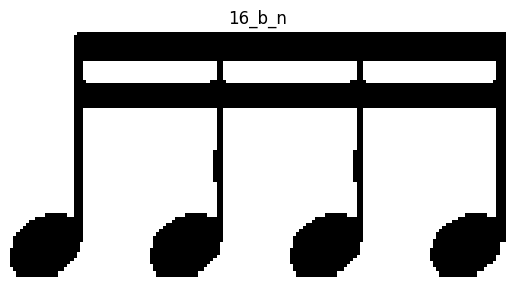

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


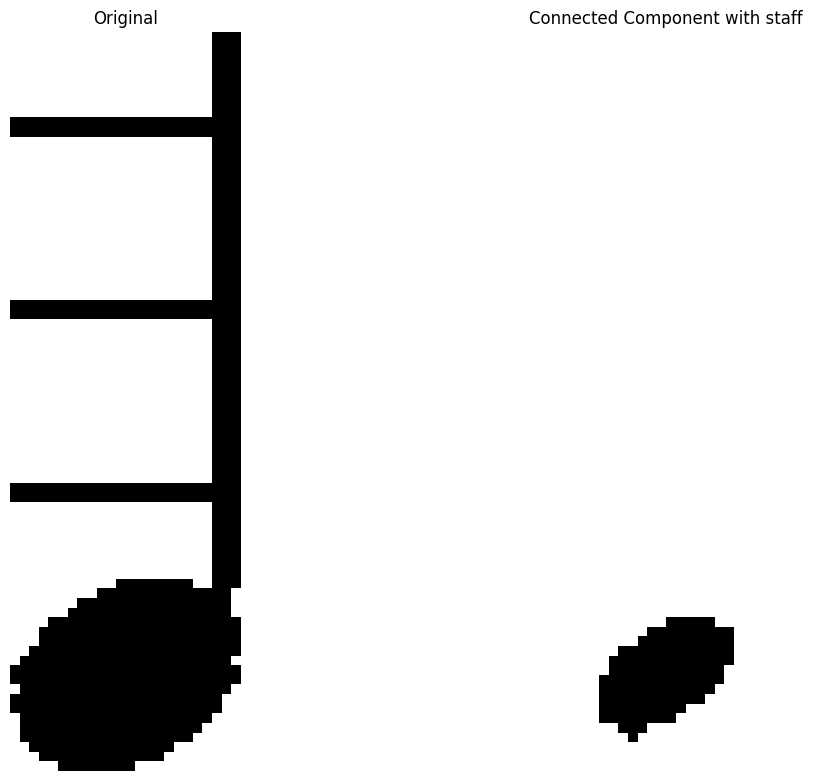

estim idx:  2
126.75
e1


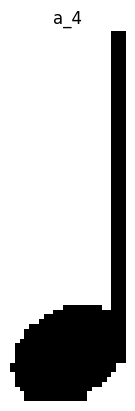

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


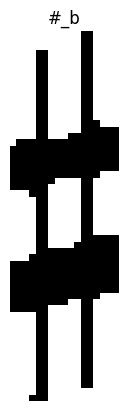

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


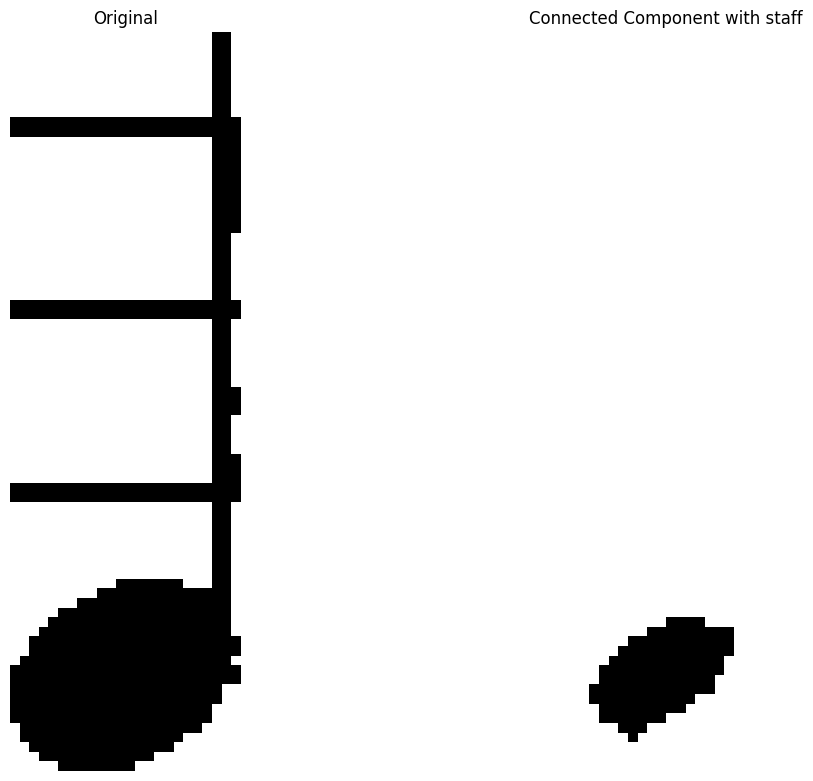

estim idx:  2
126.75
e1


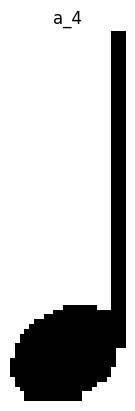

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


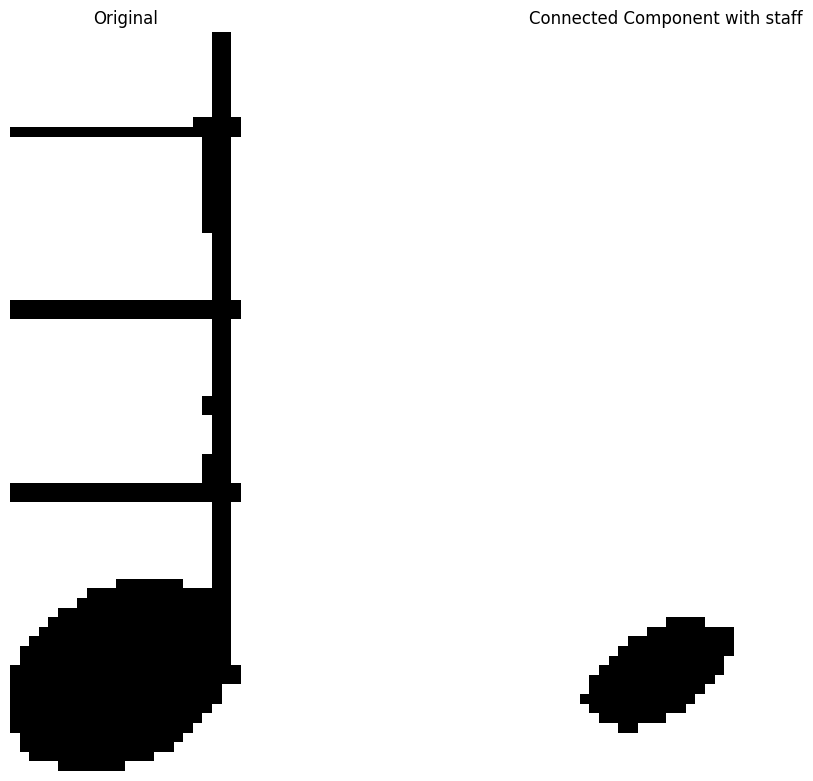

estim idx:  2
106.75
g1


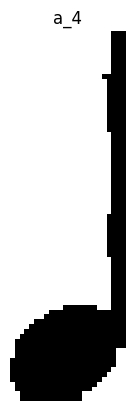

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


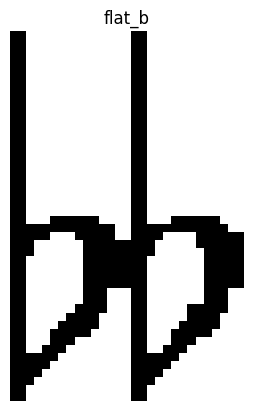

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


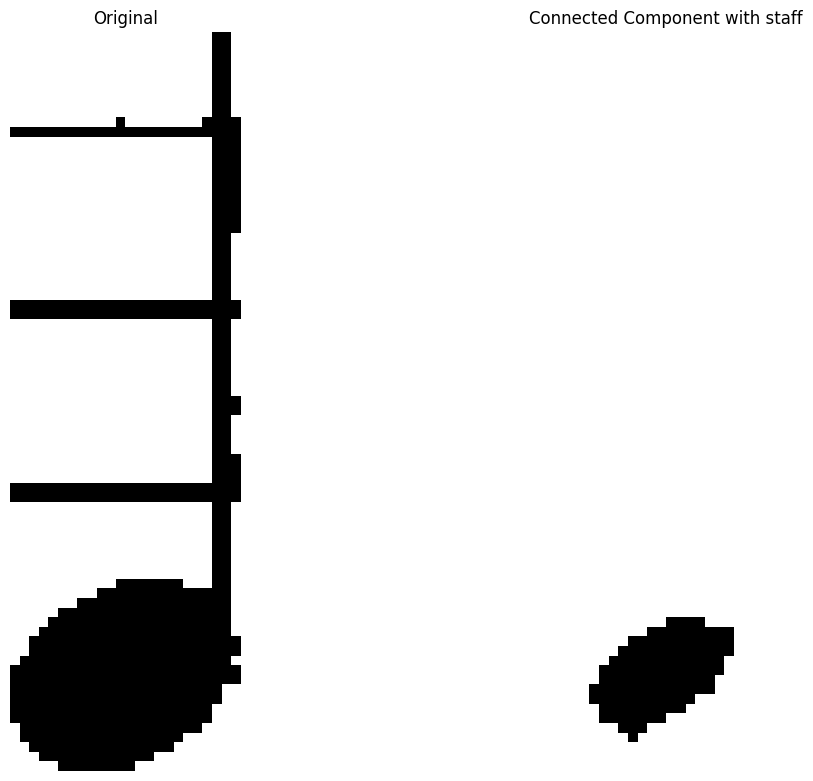

estim idx:  2
107.75
g1


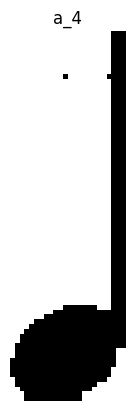

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


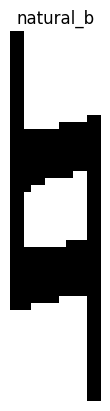

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


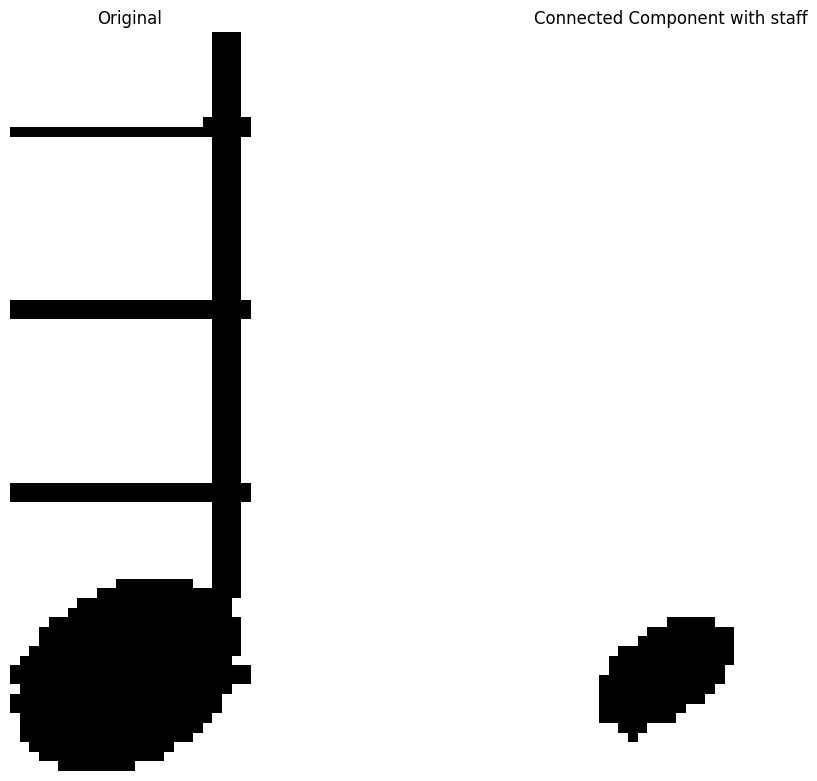

estim idx:  2
107.75
g1


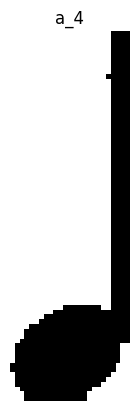

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


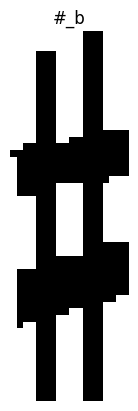

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


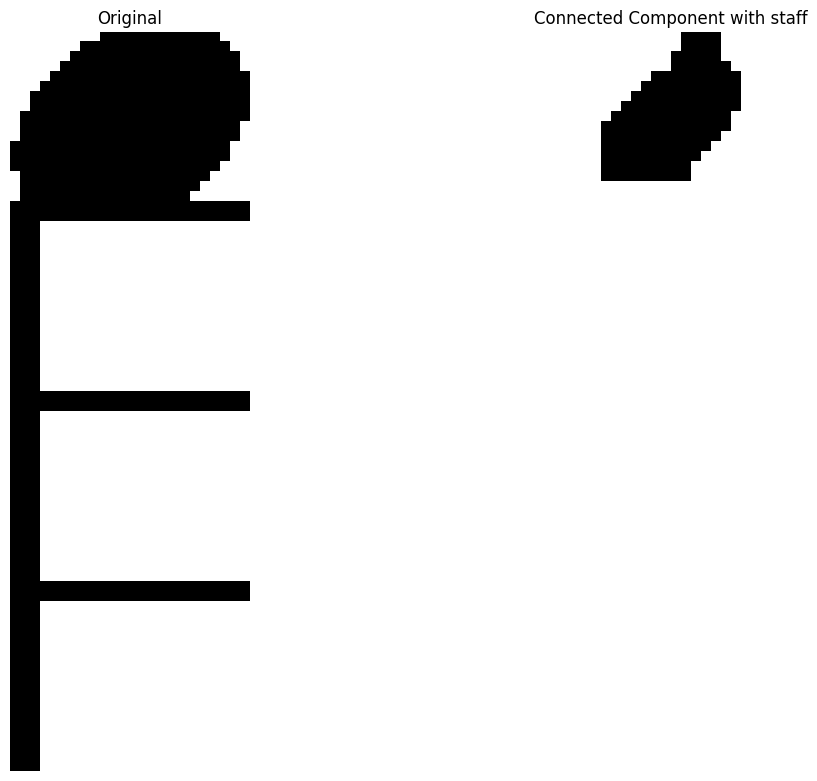

estim idx:  2
59.75
e2


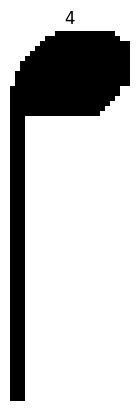

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


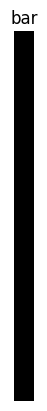

c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\motchy\Documents\codes\omr\Mozart\.venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


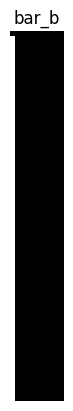

['\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', '\\meter<"4/4">', 'e1/16', 'e1/16', 'e1/16', 'e1/16', 'e1/4', 'e#1/4', 'g1/4', 'g&&1/4', 'g1/4', 'e#2/4']


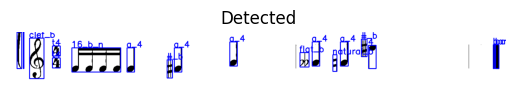

In [13]:
black_names = ['4', '8', '8_b_n', '8_b_r', '16', '16_b_n', '16_b_r', '32', '32_b_n', '32_b_r', 'a_4', 'a_8', 'a_16', 'a_32', 'chord']
ring_names = ['2', 'a_2']
whole_names = ['1', 'a_1']
disk_size = seg.most_common / 4
print(len(coord_imgs))
for i, img in enumerate(coord_imgs):
    commonfunctions.show_images([img])
    res = []
    prev = ''
    time_name = ''
    primitives, prim_with_staff, boundary = connected_componentes.get_connected_components(img, imgs_with_staff[i])
    print(boundary)  
    detected = cv2.cvtColor(np.array(255*img.copy()).astype(np.uint8),cv2.COLOR_GRAY2RGB)
    for j, prim in enumerate(primitives):
        minr, minc, maxr, maxc = boundary[j]

        prim = morphology.binary_opening(prim, morphology.square(seg.most_common-imgs_spacing[i]))
        saved_img = (255*(1 - prim)).astype(np.uint8)
        labels = fit.predict(saved_img)
        octave = None
        label = labels[0]

        cv2.rectangle(detected, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
        cv2.putText(detected, label, (minc-2, minr-2), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        if label in black_names:
            test_img = np.copy(prim_with_staff[j])
            test_img = morphology.binary_dilation(test_img, morphology.disk(disk_size))
            commonfunctions.show_images([prim_with_staff[j], test_img], ['Original', 'Connected Component with staff'])
            comps, comp_w_staff, bounds = connected_componentes.get_connected_components(test_img, prim_with_staff[j])
            comps, comp_w_staff, bounds = filter_beams(comps, comp_w_staff, bounds)
            bounds = [np.array(bound)+disk_size-2 for bound in bounds]

            if len(bounds) > 1 and label not in ['8_b_n', '8_b_r', '16_b_n', '16_b_r', '32_b_n', '32_b_r']:
                l_res = []
                bounds = sorted(bounds, key= lambda b : -b[2])
                for k in range(len(bounds)):
                    print("Bound")
                    idx, p = estim(boundary[j][0]+bounds[k][2], i)
                    l_res.append(f'{label_map[idx][p]}/4')
                    if k+1 < len(bounds) and (bounds[k][2]-bounds[k+1][2]) > 1.5*imgs_spacing[i]:
                        print("IF COND", bounds[k][2]-bounds[k+1][2], 1.25*imgs_spacing[i])
                        idx, p = estim(boundary[j][0]+bounds[k][2]-imgs_spacing[i]/2, i)
                        l_res.append(f'{label_map[idx][p]}/4')
                res.append(sorted(l_res))
            else:
                for bbox in bounds:
                    c = bbox[2]+boundary[j][0]
                    line_idx, p = estim(int(c), i)
                    l = label_map[line_idx][p]
                    res.append(get_note_name(prev, l, label))
                    print(c)
                    print(l)
        elif label in ring_names:
            head_img = 1-ndimage.binary_fill_holes(1-prim)
            head_img = morphology.binary_closing(head_img, morphology.disk(disk_size))
            comps, comp_w_staff, bounds = connected_componentes.get_connected_components(head_img, prim_with_staff[j])
            for bbox in bounds:
                c = bbox[2]+boundary[j][0]
                line_idx, p = estim(int(c), i)
                l = label_map[line_idx][p]
                res.append(get_note_name(prev, l, label))
                print(c)
                print(l)
        elif label in whole_names:
            c = boundary[j][2]
            line_idx, p = estim(int(c), i)
            l = label_map[line_idx][p]
            res.append(get_note_name(prev, l, label))
            print(c)
            print(l)
        elif label in ['bar', 'bar_b', 'clef', 'clef_b', 'natural', 'natural_b'] or label in []:
            commonfunctions.show_images([prim], [label])
            continue
        elif label in ['#', '#_b']:
            if prim.shape[0] == prim.shape [1]:
                prev = '##'
            else: 
                prev = '#'
        elif label in ['cross']:
            prev = '##'
        elif label in ['flat', 'flat_b']:
            if prim.shape[1] >= 0.5*prim.shape[0]:
                prev = '&&'
            else:
                prev = '&'
        elif label in ['dot', 'dot_b', 'p', 't24_b']:
            if len(res) == 0 or (len(res) > 0 and res[-1] in ['flat', 'flat_b', 'cross', '#', '#_b', 't24', 't24_b', 't44', 't44_b']):
                continue
            res[-1] += '.'
        elif label in ['t2', 't4']:
            time_name += label[1]
        elif label in []:
            time_name = label[1]+label[2]
        elif label == 'chord':
            print('Chord')
            img = morphology.thin(1-prim.copy(), max_iter=20)
            head_img = morphology.binary_closing(1-img, morphology.disk(disk_size))
        if label not in ['flat', 'flat_b', 'cross', '#', '#_b']:
            prev = ''
        commonfunctions.show_images([prim], [label])
        if len(time_name) == 2:
            res = ["\\" + "meter<\"" + str(time_name[0]) + "/" + str(time_name[1])+"\">"] + res
    print(res) 
    commonfunctions.show_images([detected], ['Detected'])
    cv2.imwrite(f'{img_name}_detected_{i}.png', detected)